# 🔬 W02 — Feature Selection: Correlation vs AFICv (M1–M4)
**Objective**: Compare correlation-based and stratified AFICv feature selection across all 4 machine groups for the results section.

**Author**: Fatima Khadija Benzine  
**Date**: 15 February 2026

In [1]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch

project_root = Path().resolve().parent
sys.path.insert(0, str(project_root))
sys.path.insert(0, str(project_root / 'src'))

from data_loader import MultiDatasetLoader
from preprocessing import DataNormalizer
from bi_fusion import BIFusionPipeline
from feature_selection import BIAwareFeatureSelector
from feature_selection_aficv import AFICvFeatureSelector

plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

print("All modules imported ✓")

All modules imported ✓


---
## 1. Helper: Prepare Fused Data for Any Dataset

In [2]:
loader = MultiDatasetLoader()

def prepare_fused(dataset_name):
    """Load, normalize, and fuse with BI — no feature selection."""
    ds = loader.load_cmapss_dataset(dataset_name)
    train = ds['train'].copy()
    train['rul'] = train['rul'].clip(upper=125)
    
    sensor_cols = [c for c in train.columns if c.startswith('sensor_')]
    setting_cols = [c for c in train.columns if c.startswith('setting_')]
    
    # Normalize sensors + settings
    normalizer = DataNormalizer(method='minmax')
    train = normalizer.fit_transform(train, sensor_cols + setting_cols)
    
    # Fuse with BI
    fusion = BIFusionPipeline()
    train = fusion.fuse(train, dataset_name, split='train', encode_categoricals=True)
    
    # Normalize continuous BI
    from bi_fusion import CONTINUOUS_BI_VARS
    bi_cont = [c for c in CONTINUOUS_BI_VARS if c in train.columns]
    bi_norm = DataNormalizer(method='minmax')
    train = bi_norm.fit_transform(train, bi_cont)
    
    bi_cols = fusion.get_bi_columns(train)
    
    return train, sensor_cols, setting_cols, bi_cols

print("Helper ready ✓")

Helper ready ✓


---
## 2. Run Both Methods on M1–M4

In [3]:
datasets = ['FD001', 'FD002', 'FD003', 'FD004']
labels = {'FD001': 'M1', 'FD002': 'M2', 'FD003': 'M3', 'FD004': 'M4'}
meta_cols = ['unit', 'cycle', 'rul']

results = []

for ds_name in datasets:
    print(f"\n{'='*70}")
    print(f"  {labels[ds_name]} ({ds_name})")
    print(f"{'='*70}")
    
    train, sensor_cols, setting_cols, bi_cols = prepare_fused(ds_name)
    all_features = sensor_cols + setting_cols + bi_cols
    
    # --- Method 1: Correlation-based ---
    corr_sel = BIAwareFeatureSelector(variance_threshold=0.01, correlation_threshold=0.95)
    corr_features = corr_sel.select_features(
        data=train, sensor_cols=sensor_cols,
        bi_cols=bi_cols, setting_cols=setting_cols,
        exclude_cols=meta_cols,
    )
    
    # --- Method 2: AFICv Stratified (90%) ---
    aficv_sel = AFICvFeatureSelector(
        base_learner='xgboost', n_folds=5, cumulative_threshold=0.90,
    )
    aficv_features = aficv_sel.select_features_stratified(
        data=train, sensor_cols=sensor_cols,
        bi_cols=bi_cols, setting_cols=setting_cols,
        target_col='rul', group_col='unit',
    )
    
    # Count types
    def count(feats):
        s = sum(1 for f in feats if f.startswith('sensor_') or f.startswith('setting_'))
        return s, len(feats) - s
    
    corr_s, corr_b = count(corr_features)
    aficv_s, aficv_b = count(aficv_features)
    
    results.append({
        'Machine': labels[ds_name],
        'corr_sensor': corr_s,
        'corr_bi': corr_b,
        'corr_total': len(corr_features),
        'aficv_sensor': aficv_s,
        'aficv_bi': aficv_b,
        'aficv_total': len(aficv_features),
        'corr_features': corr_features,
        'aficv_features': aficv_features,
    })

print(f"\n{'='*70}")
print("Done ✓")


  M1 (FD001)
Loading FD001 dataset...
  Files: train=True, test=True, rul=True
  - Training data shape: (20631, 26)
  - Training units: 100
  - Training RUL range: [0, 361]
  - Test data shape: (13096, 26)
  - RUL values shape: (100, 1)
  - Test units found: 100 (units: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]...)
  - RUL values provided: 100
    Unit 1: max_cycle=31, base_RUL=112
    Unit 2: max_cycle=49, base_RUL=98
    Unit 3: max_cycle=126, base_RUL=69
✓ FD001 loaded: 20631 train, 13096 test samples

=== BI Fusion: FD001 (train) ===
  Sensor data: (20631, 27)
  BI data loaded: 20631 rows, 100 units
  Fused data: (20631, 44)
  Features: 21 sensor + 17 BI

=== BI-Aware Feature Selection ===
  Input: 21 sensor + 17 BI + 3 setting = 41 total
  Variance filter (sensor/settings only):
    Removed 9: ['sensor_1', 'sensor_5', 'sensor_9', 'sensor_10', 'sensor_14', 'sensor_16', 'sensor_18', 'sensor_19', 'setting_3']
    Kept 15 sensor/setting features
    BI feature

---
## 3. Summary Table (for LaTeX)

In [4]:
summary = pd.DataFrame(results)

display_df = summary[['Machine', 
                       'corr_sensor', 'corr_bi', 'corr_total',
                       'aficv_sensor', 'aficv_bi', 'aficv_total']].copy()

display_df.columns = ['Machine',
                       'Corr: Sensor', 'Corr: BI', 'Corr: Total',
                       'AFICv: Sensor', 'AFICv: BI', 'AFICv: Total']

print("=== Feature Selection Comparison ===")
print(display_df.to_string(index=False))

# LaTeX output
print("\n=== LaTeX Table ===")
print(display_df.to_latex(index=False, column_format='@{}lcccccc@{}'))

=== Feature Selection Comparison ===
Machine  Corr: Sensor  Corr: BI  Corr: Total  AFICv: Sensor  AFICv: BI  AFICv: Total
     M1            15        17           32              8          8            16
     M2             7        17           24             11          6            17
     M3            13        17           30              7          8            15
     M4             7        17           24             10          7            17

=== LaTeX Table ===
\begin{tabular}{@{}lcccccc@{}}
\toprule
Machine & Corr: Sensor & Corr: BI & Corr: Total & AFICv: Sensor & AFICv: BI & AFICv: Total \\
\midrule
M1 & 15 & 17 & 32 & 8 & 8 & 16 \\
M2 & 7 & 17 & 24 & 11 & 6 & 17 \\
M3 & 13 & 17 & 30 & 7 & 8 & 15 \\
M4 & 7 & 17 & 24 & 10 & 7 & 17 \\
\bottomrule
\end{tabular}



---
## 4. Visual Comparison

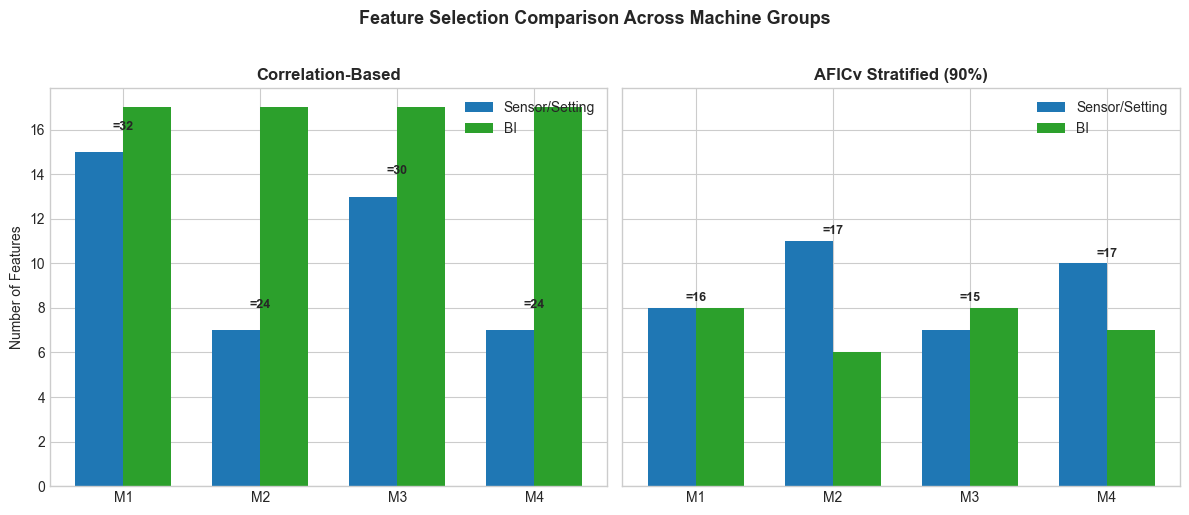

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

machines = [r['Machine'] for r in results]
x = np.arange(len(machines))
width = 0.35

# Left: Correlation-based
axes[0].bar(x - width/2, [r['corr_sensor'] for r in results], width,
            label='Sensor/Setting', color='#1f77b4')
axes[0].bar(x + width/2, [r['corr_bi'] for r in results], width,
            label='BI', color='#2ca02c')
for i, r in enumerate(results):
    axes[0].text(i, r['corr_total'] - max(r['corr_sensor'], r['corr_bi']) + 1,
                 f"={r['corr_total']}", ha='center', fontweight='bold', fontsize=9)
axes[0].set_xticks(x)
axes[0].set_xticklabels(machines)
axes[0].set_ylabel('Number of Features')
axes[0].set_title('Correlation-Based', fontweight='bold')
axes[0].legend()

# Right: AFICv Stratified 90%
axes[1].bar(x - width/2, [r['aficv_sensor'] for r in results], width,
            label='Sensor/Setting', color='#1f77b4')
axes[1].bar(x + width/2, [r['aficv_bi'] for r in results], width,
            label='BI', color='#2ca02c')
for i, r in enumerate(results):
    axes[1].text(i, max(r['aficv_sensor'], r['aficv_bi']) + 0.3,
                 f"={r['aficv_total']}", ha='center', fontweight='bold', fontsize=9)
axes[1].set_xticks(x)
axes[1].set_xticklabels(machines)
axes[1].set_title('AFICv Stratified (90%)', fontweight='bold')
axes[1].legend()

fig.suptitle('Feature Selection Comparison Across Machine Groups',
             fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('Feature_Selection_Comparison_M1_M4.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 5. Feature Overlap Analysis

In [6]:
for r in results:
    corr_set = set(r['corr_features'])
    aficv_set = set(r['aficv_features'])
    common = corr_set & aficv_set
    only_corr = corr_set - aficv_set
    only_aficv = aficv_set - corr_set
    
    print(f"\n--- {r['Machine']} ---")
    print(f"  Common ({len(common)}):     {sorted(common)}")
    print(f"  Only Corr ({len(only_corr)}):  {sorted(only_corr)}")
    print(f"  Only AFICv ({len(only_aficv)}): {sorted(only_aficv)}")


--- M1 ---
  Common (15):     ['cm_cost', 'downtime_penalty', 'labor_rate_overtime', 'labor_rate_standard', 'revenue_per_hour', 'sensor_11', 'sensor_12', 'sensor_15', 'sensor_17', 'sensor_20', 'sensor_4', 'sensor_7', 'spare_parts_available', 'spare_parts_lead_time', 'technician_available']
  Only Corr (17):  ['contract_penalty_active', 'maintenance_window', 'pm_cost', 'production_priority_0', 'production_priority_1', 'production_priority_2', 'sensor_13', 'sensor_2', 'sensor_21', 'sensor_3', 'sensor_6', 'sensor_8', 'setting_1', 'setting_2', 'shift_pattern_0', 'shift_pattern_1', 'shift_pattern_2']
  Only AFICv (1): ['sensor_9']

--- M2 ---
  Common (10):     ['cm_cost', 'downtime_penalty', 'labor_rate_standard', 'pm_cost', 'production_priority_2', 'sensor_11', 'sensor_14', 'sensor_16', 'sensor_4', 'technician_available']
  Only Corr (14):  ['contract_penalty_active', 'labor_rate_overtime', 'maintenance_window', 'production_priority_0', 'production_priority_1', 'revenue_per_hour', 'senso

---
## 6. AFICv: Top BI Features Across Datasets
Which BI features are consistently selected?

In [7]:
# Re-run to collect BI importance tables
bi_rankings = {}

for ds_name in datasets:
    train, sensor_cols, setting_cols, bi_cols = prepare_fused(ds_name)
    
    sel = AFICvFeatureSelector(
        base_learner='xgboost', n_folds=5, cumulative_threshold=0.90,
    )
    sel.select_features_stratified(
        data=train, sensor_cols=sensor_cols,
        bi_cols=bi_cols, setting_cols=setting_cols,
        target_col='rul', group_col='unit',
    )
    
    imp_bi = sel.get_importance_table(group='bi')
    bi_rankings[labels[ds_name]] = imp_bi[['feature', 'normalized']].copy()

# Combine into one table
combined = bi_rankings['M1'].rename(columns={'normalized': 'M1'})
for m in ['M2', 'M3', 'M4']:
    combined = combined.merge(
        bi_rankings[m].rename(columns={'normalized': m}),
        on='feature', how='outer'
    )

combined['mean_rank'] = combined[['M1', 'M2', 'M3', 'M4']].mean(axis=1)
combined = combined.sort_values('mean_rank', ascending=False).reset_index(drop=True)

print("=== BI Feature Importance Across Datasets (normalized, within BI group) ===")
print(combined.to_string(index=False, float_format='%.3f'))

Loading FD001 dataset...
  Files: train=True, test=True, rul=True
  - Training data shape: (20631, 26)
  - Training units: 100
  - Training RUL range: [0, 361]
  - Test data shape: (13096, 26)
  - RUL values shape: (100, 1)
  - Test units found: 100 (units: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]...)
  - RUL values provided: 100
    Unit 1: max_cycle=31, base_RUL=112
    Unit 2: max_cycle=49, base_RUL=98
    Unit 3: max_cycle=126, base_RUL=69
✓ FD001 loaded: 20631 train, 13096 test samples

=== BI Fusion: FD001 (train) ===
  Sensor data: (20631, 27)
  BI data loaded: 20631 rows, 100 units
  Fused data: (20631, 44)
  Features: 21 sensor + 17 BI

AFICv Feature Selection (Stratified)
  Learner: xgboost, K=5
  Sensor/Setting: 24 candidates, threshold=90%
  BI:             17 candidates, threshold=90%

--- Sensor/Setting Group (24 features) ---
  [Sensor] Fold 1/5: R²=0.8358
  [Sensor] Fold 2/5: R²=0.7660
  [Sensor] Fold 3/5: R²=0.8136
  [Sensor] Fold 4/5: R²=0.796

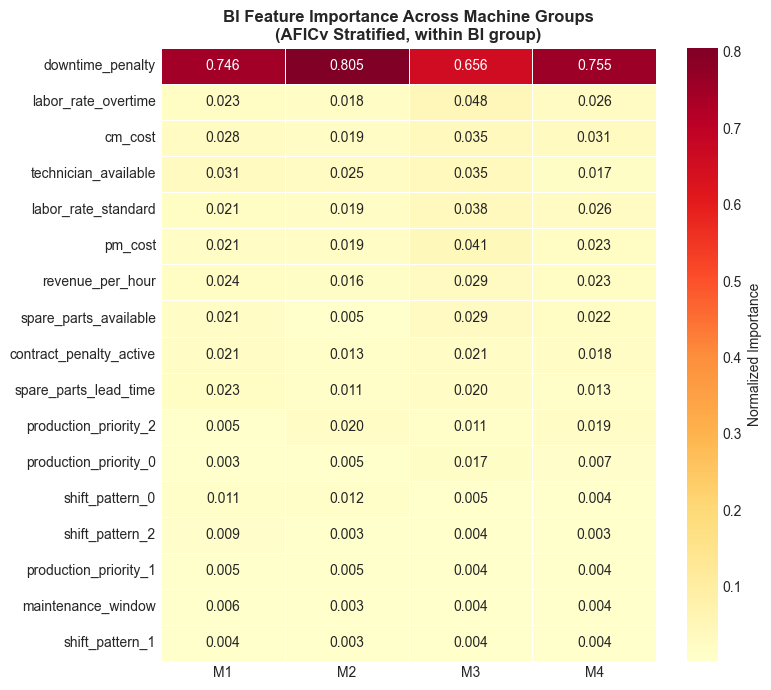

In [8]:
# Heatmap
plot_data = combined.set_index('feature')[['M1', 'M2', 'M3', 'M4']]

fig, ax = plt.subplots(figsize=(8, 7))
sns.heatmap(plot_data, annot=True, fmt='.3f', cmap='YlOrRd',
            linewidths=0.5, ax=ax, cbar_kws={'label': 'Normalized Importance'})
ax.set_title('BI Feature Importance Across Machine Groups\n(AFICv Stratified, within BI group)',
             fontweight='bold')
ax.set_ylabel('')
plt.tight_layout()
plt.savefig('BI_Feature_Importance_Heatmap_M1_M4.png', dpi=150, bbox_inches='tight')
plt.show()